### Organize BCH data (Now ported to readEDF.py)

The purpose of this is to organize the downloaded data into a dictionary. <br>
key: patient <br>
value: data <br>
> column 0: time (seconds) <br>
> column 1: Seizure yes/no <br>
> column 2: Time until next seizure. Value will be thresholded to [0, MAX_TIME] <br>
> column 3-n: Raw data from ECG <br>

*Since not all the patients have data for all the ECG (and some have extra leads) just be careful

In [43]:
def extract_summary_data(f, temp_d):
    summary = f.read()
    summary = summary.split('\n\n')
    temp_d['freq'] = float(summary[0].split(' ')[3])
    for line in summary:
        if 'File Name:' in line:
            temp = filter(None, line.split('\n'))
            key = temp[0].split(' ')[2]
            if len(temp) == 4:
                temp_d[key] = []
                continue
            temp = temp[4:]
            seizure_time = []
            for x,y in zip(temp[0::2], temp[1::2]):
                x = int(x.split(' ')[-2])
                y = int(y.split(' ')[-2])
                seizure_time.append((x,y))
            temp_d[key] = seizure_time

def read_edf(filename):
    f = pyedflib.EdfReader(os.path.join(root, filename))
    assert(np.all(f.getSampleFrequencies() == f.getSampleFrequencies()[0]))
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    return sigbufs, f.getSignalLabels()
    
def label_edf(sigbufs, seizure_time, eeg_label):
    time = np.arange(sigbufs.shape[1])/temp_d['freq']
    seizure_id = np.zeros(sigbufs.shape[1])
    seizure_delay = np.zeros(sigbufs.shape[1])
    if seizure_time:
        prev_end = 0
        for x,y in seizure_time:
            start_idx = int(temp_d['freq']*x)
            end_idx = int(temp_d['freq']*y)+1 # Include the end point within the data
            seizure_id[start_idx:end_idx].fill(1)
            seizure_delay[prev_end:start_idx] = np.arange(start_idx-prev_end)[::-1]/temp_d['freq']
            seizure_delay[end_idx:].fill(np.inf)
            prev_end = end_idx
    else:
        seizure_delay += np.inf
    df = np.vstack([time, seizure_id, seizure_delay, sigbufs])
    df = df.T
    df = df.astype('float32')
    eeg_label = ['time', 'seizure', 'seizure_delay'] + eeg_label
    df = pd.DataFrame(df, columns=eeg_label)
    df['seizure'] = df['seizure'].astype('int8')
    return df

# Use the function like this
# df = read_single_edf('chb10_89.edf')
def read_single_edf(filename):
    if '/' not in filename:
        data_folder = '/'.join(os.getcwd().split('/')[:-1]) + '/ANES212_data/'
        patient_folder = filename.split('_')[0]
        filename = data_folder + patient_folder + '/' + filename
    else:
        data_folder = '/'.join(os.getcwd().split('/')[:-1]) + '/ANES212_data/'
        patient_folder = filename.split('/')[-2]
    
    # Extract label data for the filename (e.g. start and end of seizures if any)
    summary_file = data_folder + patient_folder + '/' + patient_folder + '-summary.txt'
    d_temp = []
    with open(summary_file, 'rb') as f:
        extract_summary_data(f, temp_d)
    
    # Now read edf and label
    sigbufs, eeg_label = read_edf(full_path)
    df = label_edf(sigbufs, temp_d[filename.split('/')[-1]], eeg_label)
    return df

In [45]:
# Converts all edf to csv for readability
# Takes up a lot of memory so may not be ideal

%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyedflib
import re

# Parameter
patient_folder_list = []

# Load data from data_folder
data_folder = '/'.join(os.getcwd().split('/')[:-1]) + '/ANES212_data/'
patient_dict = {}
for root, dirs, files in os.walk(data_folder):
    df_list = []
    if any([patient_folder in root for patient_folder in patient_folder_list]):
        temp_d = {} # Stores data from the summary txt file
        for filename in files:
            full_path = os.path.join(root, filename)
            print filename
            if '.edf'in filename and '.seizures' not in filename:
                sigbufs, eeg_label = read_edf(full_path)
                df = label_edf(sigbufs, temp_d[filename], eeg_label)
                df_filename = os.path.join(root, filename.split('.')[0]) + '.csv'
                #df.to_csv(df_filename, sep='\t')
            elif '-summary.txt' in filename:
                with open(full_path, 'rb') as f:
                    extract_summary_data(f, temp_d)

In [108]:
print vars(f)
print dir(f)
print f.getSignalLabels()

{'file_name': '/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb04/chb04_05.edf'}
['__class__', '__del__', '__delattr__', '__dict__', '__doc__', '__enter__', '__exit__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_close', '_convert_string', '_get_float', 'admincode', 'annotations_in_file', 'birthdate', 'check_open_ok', 'datarecord_duration', 'datarecords_in_file', 'digital_max', 'digital_min', 'equipment', 'file_duration', 'file_info', 'file_info_long', 'file_name', 'gender', 'getAdmincode', 'getBirthdate', 'getDigitalMaximum', 'getDigitalMinimum', 'getEquipment', 'getFileDuration', 'getGender', 'getHeader', 'getLabel', 'getNSamples', 'getPatientAdditional', 'getPatientCode', 'getPatientName', 'getPhysicalDimension', 'getPhysicalMaximum', 'getPhysicalMinimum', 'getPrefilter', 'getRecordingAdditional', 'getSampl

### Testing readEDF.py

In [38]:
%run scripts/readEDF.py

#df = read_single_edf('chb10_89.edf')
df = read_patient_edf('chb10')

In [34]:
df.loc[(df['seizure']==1) & (df['seizure_delay']==0)].head()

,time,seizure,seizure_delay,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,...,F8-T8,T8-P8,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8
354048,1383.000000,1,0.0,28.424908,294.505493,-80.586082,-146.813187,-120.439560,236.483521,-22.564102,...,-30.183149,-154.432236,69.450546,-140.952377,-3.223443,81.172165,-35.457874,-108.131866,-115.164833,-154.432236
354049,1383.003906,1,0.0,28.424908,290.402924,-68.278389,-152.087906,-117.509155,237.069595,-23.150183,...,-37.216118,-150.915756,70.036629,-129.230774,-10.256411,68.864471,-35.457874,-101.684982,-120.439560,-150.915756
354050,1383.007812,1,0.0,30.183149,294.505493,-67.106224,-155.018311,-114.578758,235.897430,-26.080585,...,-44.249084,-143.882782,70.622711,-120.439560,-16.117216,67.692307,-37.802197,-102.271065,-126.300369,-143.882782
354051,1383.011719,1,0.0,30.183149,293.333344,-71.208794,-152.087906,-111.648354,232.967026,-33.113552,...,-53.040295,-134.505493,69.450546,-115.750916,-21.978022,71.794868,-37.216118,-104.615387,-132.747253,-134.505493
354052,1383.015625,1,0.0,34.285713,288.644684,-79.413918,-146.813187,-111.062271,223.589737,-38.974358,...,-58.901100,-128.058609,66.520149,-113.406593,-24.908424,80.000000,-33.113552,-113.406593,-134.505493,-128.058609
354053,1383.019531,1,0.0,43.076923,283.369965,-90.549454,-142.124542,-111.062271,213.040298,-38.388279,...,-62.417583,-121.025642,63.003662,-116.336998,-26.080585,91.135529,-30.769230,-128.644684,-130.989014,-121.025642
354054,1383.023438,1,0.0,46.593407,273.992676,-89.963371,-138.608063,-113.992676,207.179489,-36.630035,...,-63.003662,-111.062271,55.970695,-118.681320,-20.219780,90.549454,-22.564102,-138.021973,-127.472527,-111.062271
354055,1383.027344,1,0.0,47.179485,259.340668,-78.827835,-132.161179,-119.853477,214.798538,-37.802197,...,-60.659340,-99.926743,51.868134,-117.509155,-12.600733,79.413918,-12.014652,-143.882782,-119.267403,-99.926743
354056,1383.031250,1,0.0,46.007324,252.893768,-67.106224,-126.300369,-125.714287,234.725281,-36.043957,...,-54.798534,-89.377289,48.351650,-111.062271,-1.465201,67.692307,-10.842491,-146.813187,-105.787544,-89.377289
354057,1383.035156,1,0.0,42.490841,253.479858,-57.728939,-119.267403,-129.230774,258.168488,-35.457874,...,-46.593407,-76.483513,43.663002,-99.926743,6.153846,58.315018,-19.633699,-137.435898,-94.652016,-76.483513


# STFT Sliding Window

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import butter, lfilter, freqz
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
from scipy.fftpack import fft

In [5]:
Sxx.shape

(257, 2049)

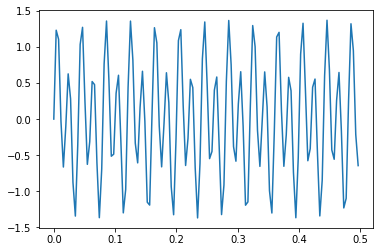

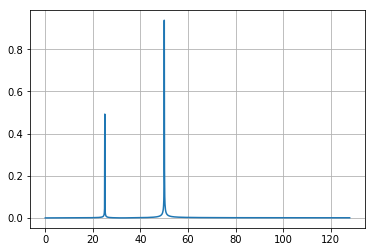

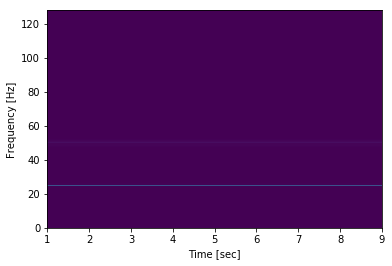

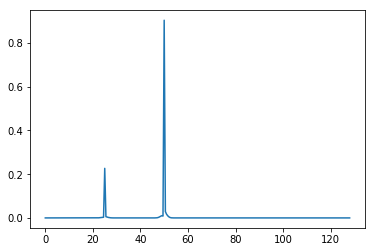

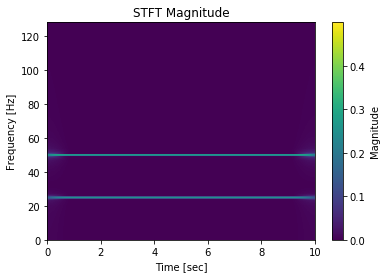

(257, 2561)


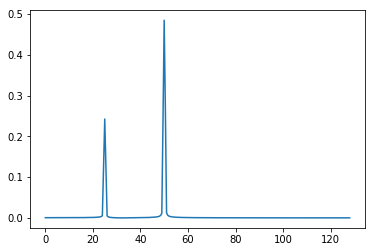

In [2]:
from scipy.fftpack import fft
# Number of sample points
# sample spacing
fs = 256
total_time = 10
N = int(fs*total_time)
t = np.linspace(0.0, N/fs, N)
y = np.sin(50.0 * 2.0*np.pi*t) + 0.5*np.sin(25.0 * 2.0*np.pi*t)
plt.plot(t[:fs//2],y[:fs//2])
plt.show()

yf = fft(y)
xf = np.linspace(0.0, fs/(2.0), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

f, ts, Sxx = signal.spectrogram(y, fs, nperseg=fs*2, noverlap=fs*2-1)
#Sxx = 20*np.log10(Sxx)
plt.pcolormesh(ts, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

plt.plot(f, np.mean(Sxx,axis=1))
plt.show()

f, ts, Zxx = signal.stft(y, fs, window='hanning', nperseg=fs*2, noverlap=fs*2-1)
Zxx = np.abs(Zxx)
plt.pcolormesh(ts, f, Zxx)
plt.colorbar(label='Magnitude')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
print Zxx.shape
plt.plot(f, np.mean(Zxx, axis=1))
plt.show()

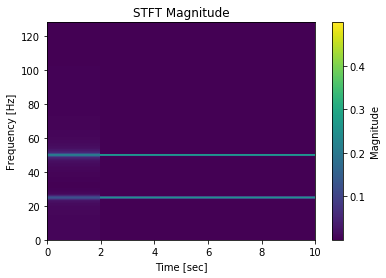

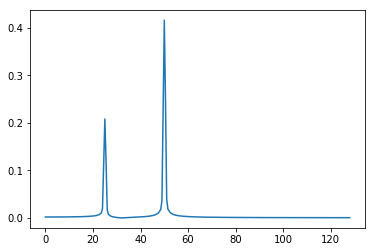

In [22]:
from scipy.fftpack import fft
fs = 256
total_time = 10
N = int(fs*total_time)
t = np.linspace(0.0, N/fs, N)
y = np.sin(50.0 * 2.0*np.pi*t) + 0.5*np.sin(25.0 * 2.0*np.pi*t)

f, ts, Zxx = signal.stft(y, fs, window='hanning', nperseg=fs*2, noverlap=0)
Zxx = np.abs(Zxx)
plt.pcolormesh(ts, f, Zxx)
plt.colorbar(label='Magnitude')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
plt.plot(f, np.mean(Zxx, axis=1))
plt.show()

## Testing STFT on Dataset
Seems like sliding sliding window takes too long (~2.5 minutes/.edf file. Total time > 24 hours)

In [3]:
import time
%run scripts/LMS.py
%run scripts/readEDF.py

df = {}
df['chb01_03'] = read_single_edf('chb01_03')


0


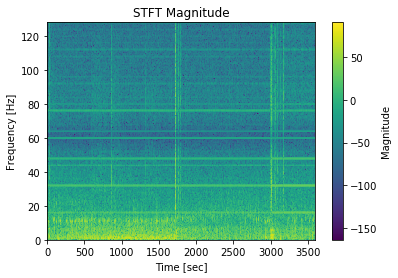

0.502158880234


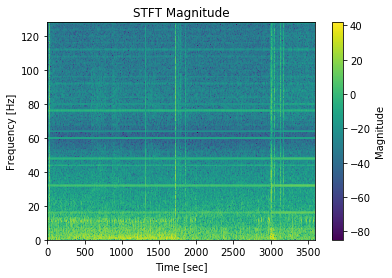

0.442771911621


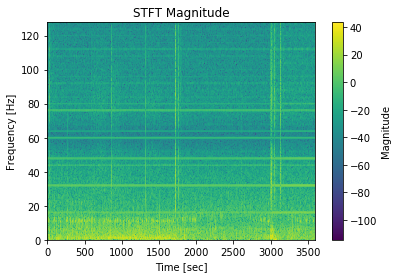

155.742892027


In [50]:
fs = 256
for key, value in df.iteritems():
    temp = value.as_matrix()[:,3:]
    for idx in range(temp.shape[1]):
        print idx
        start = time.time()
        f, ts, Zxx = signal.spectrogram(temp[:,idx], fs, window='hanning', nperseg=fs*2, noverlap=0)
        Zxx = 20*np.log10(Zxx)
        plt.pcolormesh(ts, f, Zxx)
        plt.colorbar(label='Magnitude')
        plt.title('STFT Magnitude')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
        print time.time() - start        
        
        start = time.time()
        f, ts, Zxx = signal.stft(temp[:,idx], fs, window='hanning', nperseg=fs*2, noverlap=0)
        Zxx = np.abs(Zxx)
        Zxx = 20*np.log10(Zxx)
        plt.pcolormesh(ts, f, Zxx)
        plt.colorbar(label='Magnitude')
        plt.title('STFT Magnitude')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
        print time.time() - start
        
        start = time.time()
        f, ts, Zxx = signal.stft(temp[:,idx], fs, window='hanning', nperseg=fs*2+1, noverlap=fs*2)
        Zxx = np.abs(Zxx)
        Zxx = 20*np.log10(Zxx)
        plt.pcolormesh(ts, f, Zxx)
        plt.colorbar(label='Magnitude')
        plt.title('STFT Magnitude')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
        print time.time()-start
        break

In [23]:
fs = 256
for key, value in df.iteritems():
    temp = value.as_matrix()[:,3:]
    for idx in range(temp.shape[1]):
        f, ts1, Zxx1 = signal.spectrogram(temp[:,idx], fs, window='hanning', nperseg=fs*2, noverlap=0)
        f, ts2, Zxx2 = signal.stft(temp[:,idx], fs, window='hanning', nperseg=fs*2, noverlap=0)
        break

print Zxx1.shape, Zxx2.shape, temp[:,idx].shape[0]/(2*fs)
print ts1
print ts2, value.as_matrix()[:,0][-1]


# Both work well

(257, 1800) (257, 1801) 1800
[  1.00000000e+00   3.00000000e+00   5.00000000e+00 ...,   3.59500000e+03
   3.59700000e+03   3.59900000e+03]
[  0.00000000e+00   2.00000000e+00   4.00000000e+00 ...,   3.59600000e+03
   3.59800000e+03   3.60000000e+03] 3600.0
